In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Ridership Open Lakehouse Demo (Part 2): Time-Series forecasting of ridership data

This notebook will demonstrate a strategy to implement an open lakehouse on GCP, using Apache Iceberg, as an open source standard for managing data, while still leveraging GCP native capabilities. This demo will use BigQuery Manged Iceberg Tables, Managed Apache Kafka and Apache Kafka Connect to ingest streaming data, Vertex AI for Generative AI queries on top of the data and Dataplex to govern tables.

This notebook will use ridership data and ML models to generate a time-series forcasting of ridership in the future.

We will evaluate the models accuracy and generate future data to be used in the next chapters for real-time predictions and alerting.

## Setup the environment

In [14]:
import os
USER_AGENT = "cloud-solutions/data-to-ai-nb-v3"

PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[0]
BQ_DATASET = "ridership_lakehouse"
BUCKET_NAME = f"{PROJECT_ID}-ridership-lakehouse"
LOCATION = "us-central1"

print(PROJECT_ID)
print(BUCKET_NAME)

lakehouse-demo-1000
lakehouse-demo-1000-ridership-lakehouse


### Create visualization helper functions


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def display_columns_as_rows(data):
  display_data = data.transpose()
  styler = display_data.style
  styler.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: right;'},
    {'selector': 'th.row_heading', 'props': 'text-align: right;'},
    {'selector': 'td', 'props': 'text-align: right;'},
    ], overwrite=False)
  display(styler)

def plot_historical_and_forecast(title,
                                 historical_data,
                                 timestamp_col_name,
                                 data_col_name,
                                 forecast_output=None,
                                 actual=None):

    historical_data = historical_data.sort_values(timestamp_col_name)


    figure = plt.figure(figsize=(20, 6))
    # plt.xlabel('Date and time')

    # Plot the input historical data
    plt.ylabel('Number of riders')
    plt.plot(historical_data[timestamp_col_name], historical_data[data_col_name], label = 'Historical')


    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['prediction_interval_lower_bound']
        upper_CI = forecast_output['prediction_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4,
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')

    # Display title, legend
    plt.title(f'{title}', fontsize=20)
    plt.legend(loc = 'upper center', prop={'size': 14})

# Generate ridership data

Let's assume that bus ridership depends on a number of factors:
  * Month
  * Day of week
  * Time of day
  * Hour of day
  * Date
  
  We will use the data generated in notebooks 1 & 2 to forecast ridership, based on these factors.

### Create ridership table

In [2]:
%%bigquery

CREATE TABLE IF NOT EXISTS `ridership_lakehouse.ridership_features` AS
SELECT
  transit_timestamp,
  EXTRACT(MONTH from transit_timestamp) AS transit_month,
  EXTRACT(DAYOFWEEK from transit_timestamp) AS transit_day_of_week,
  EXTRACT(TIME from transit_timestamp) AS transit_time_of_day,
  EXTRACT(HOUR from transit_timestamp) AS transit_hour,
  EXTRACT(DATE from transit_timestamp) AS transit_date,
  station_id,
  ridership.ridership
FROM ridership_lakehouse.ridership



Query is running:   0%|          |

""


### Visualize Projected data

Let's take a look at the last 20 days of generated data. The first bus stop graph also shows the temperature and percipitation values.

In [35]:
%%bigquery ridership_history
DECLARE max_ts TIMESTAMP DEFAULT (SELECT MAX(transit_timestamp) FROM ridership_lakehouse.ridership_features);
SELECT *
  FROM `ridership_lakehouse.ridership_features`
  WHERE transit_timestamp > TIMESTAMP_SUB(max_ts, INTERVAL 90 DAY)

Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
ridership_history.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54524520 entries, 0 to 54524519
Data columns (total 8 columns):
 #   Column               Dtype              
---  ------               -----              
 0   transit_timestamp    datetime64[us, UTC]
 1   transit_month        Int64              
 2   transit_day_of_week  Int64              
 3   transit_time_of_day  dbtime             
 4   transit_hour         Int64              
 5   transit_date         dbdate             
 6   station_id           Int64              
 7   ridership            Int64              
dtypes: Int64(5), datetime64[us, UTC](1), dbdate(1), dbtime(1)
memory usage: 3.5 GB


<ipython-input-37-84b49dcc39cd>:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


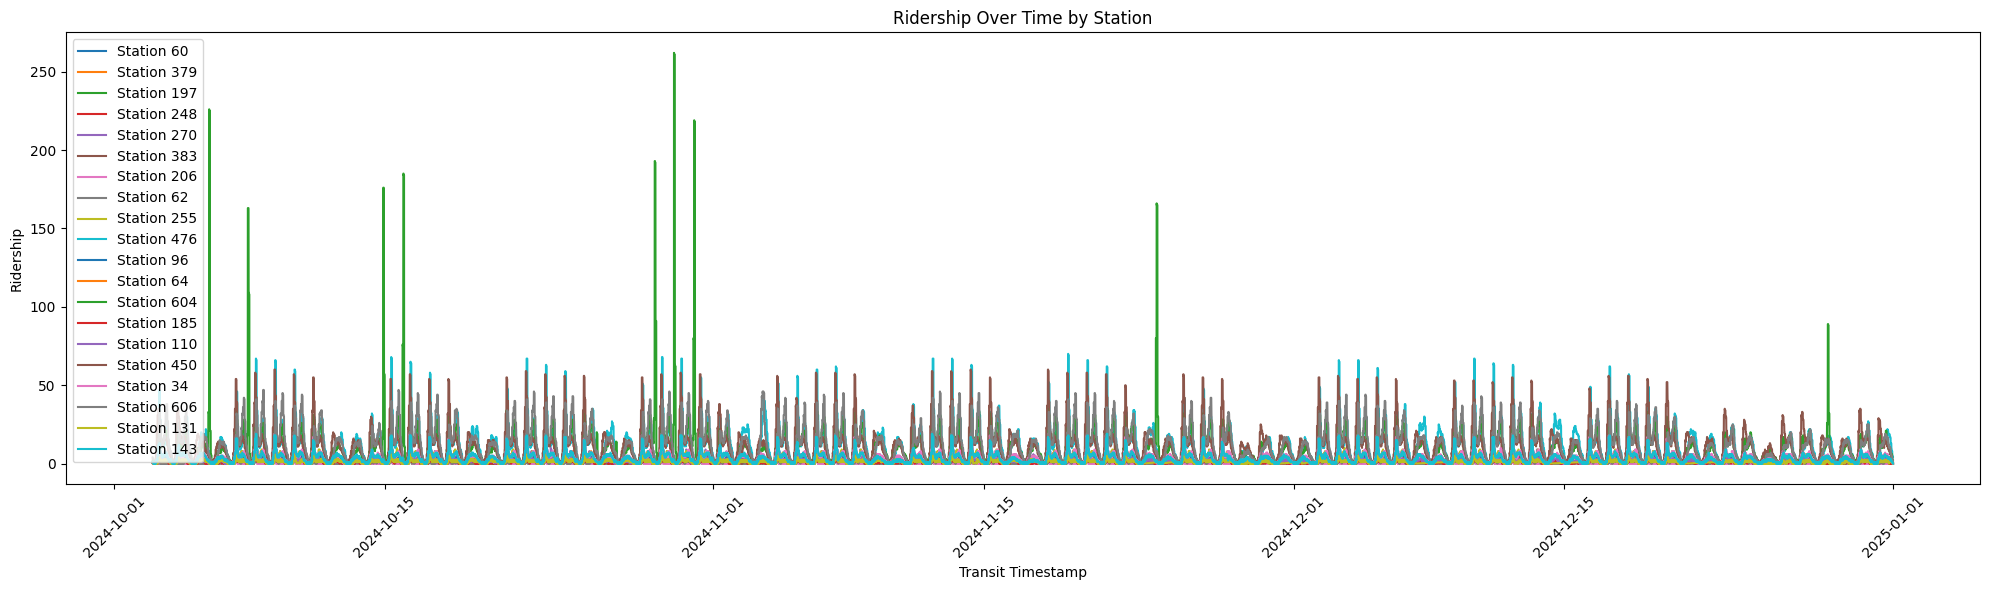

In [37]:
# prompt: Dispaly line charts for the `ridership_history` dataset, one with just the `transit_timestamp` on the x axis, `ridership` on the y axis and split lines by the `station_id`

import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(42)

# we'll sample 20 random stations, as displaying all of them is not practical
station_ids = random.sample(list(ridership_history.station_id.unique()), k=20)

figure = plt.figure(figsize=(20, 6))
plt.xlabel('Timestamp')
# Group data by station ID
for station_id in station_ids:
  station_data = ridership_history[ridership_history['station_id'] == station_id].sort_values(by="transit_timestamp")
  # Plot ridership over time for the current station
  plt.plot(station_data['transit_timestamp'], station_data['ridership'], label=f'Station {station_id}')

# Customize the plot
plt.xlabel('Transit Timestamp')
plt.ylabel('Ridership')
plt.title('Ridership Over Time by Station')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

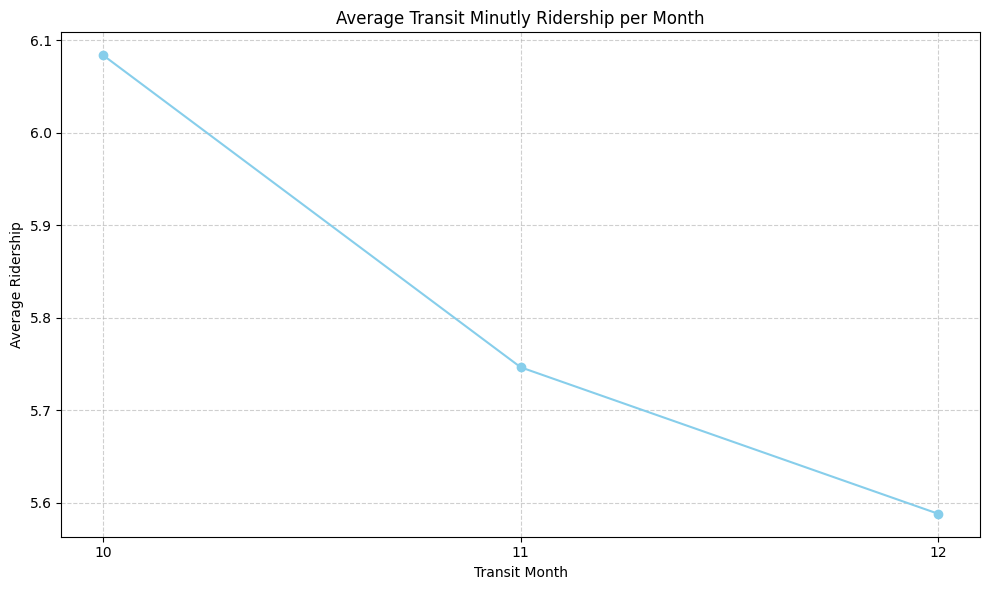

In [39]:

# Generate New Visualization: Average Ridership per Month --- This is limited due to us selecting only the last 3 months of the dataset, so extend to show more months,

# Calculate average ridership per month
# Group by 'transit_month' and calculate the mean of 'ridership'
average_ridership_per_month = ridership_history.groupby('transit_month')['ridership'].mean().reset_index()

# Sort by month to ensure correct chronological order in the plot
average_ridership_per_month = average_ridership_per_month.sort_values(by='transit_month')

plt.figure(figsize=(10, 6)) # Adjust figure size

plt.plot(average_ridership_per_month['transit_month'], average_ridership_per_month['ridership'], marker='o', linestyle='-', color='skyblue')

# Add plot labels and title
plt.xlabel("Transit Month")
plt.ylabel("Average Ridership")
plt.title("Average Transit Minutly Ridership per Month")
plt.xticks(average_ridership_per_month['transit_month']) # Ensure all months are shown on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:

# Convert transit_time_of_day to a numerical representation (total seconds from midnight)
ridership_history['time_in_seconds'] = ridership_history['transit_time_of_day'].apply(
    lambda t: t.hour * 3600 + t.minute * 60 + t.second
)

# Calculate average ridership per exact time of day (minutes and seconds are part of it)
average_ridership_per_exact_time = ridership_history.groupby('time_in_seconds')['ridership'].mean().reset_index()

# Sort by time in seconds to ensure correct chronological order
average_ridership_per_exact_time = average_ridership_per_exact_time.sort_values(by='time_in_seconds')

plt.figure(figsize=(14, 7)) # Adjust figure size

plt.plot(average_ridership_per_exact_time['time_in_seconds'], average_ridership_per_exact_time['ridership'], linestyle='-', color='mediumseagreen', alpha=0.7)

# Add plot labels and title
plt.xlabel("Transit Time of Day")
plt.ylabel("Average Ridership")
plt.title("Average Transit Ridership by Exact Time of Day")
plt.grid(True, linestyle='--', alpha=0.6)

# Improve x-axis readability: Convert seconds back to HH:MM for ticks
max_seconds = 24 * 3600
tick_interval_seconds = 3 * 3600 # Every 3 hours
tick_locations = np.arange(0, max_seconds + tick_interval_seconds, tick_interval_seconds) # Ensure 24:00 is included
tick_labels = [time(int(s / 3600), int((s % 3600) / 60)).strftime('%H:%M') for s in tick_locations]

plt.xticks(tick_locations, tick_labels, rotation=45, ha='right') # Rotate labels for better fit
plt.tight_layout()
plt.show()


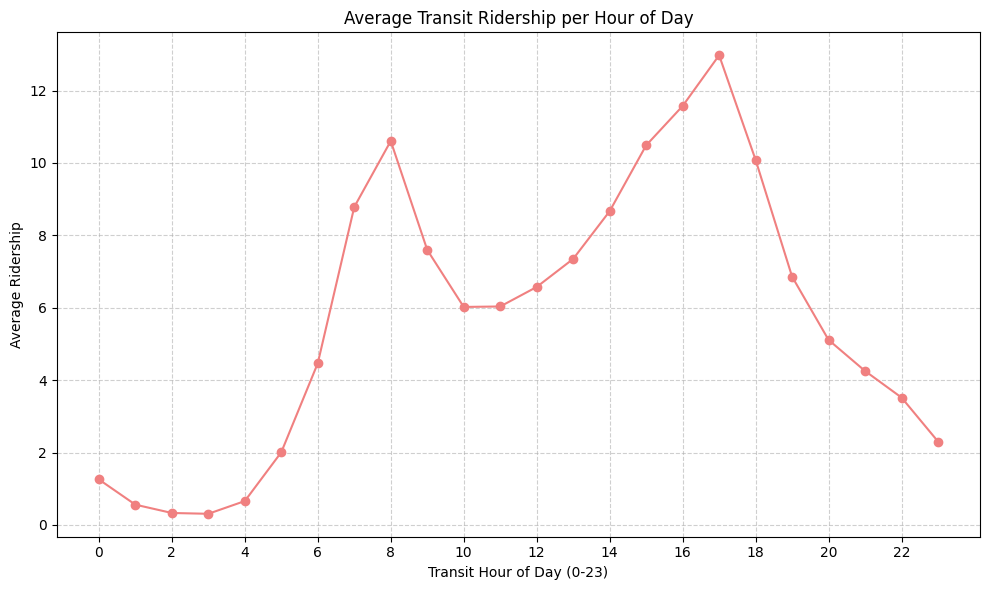

In [42]:
average_ridership_per_hour = ridership_history.groupby('transit_hour')['ridership'].mean().reset_index()

# Sort by hour to ensure correct chronological order
average_ridership_per_hour = average_ridership_per_hour.sort_values(by='transit_hour')

plt.figure(figsize=(10, 6)) # Adjust figure size

plt.plot(average_ridership_per_hour['transit_hour'], average_ridership_per_hour['ridership'], marker='o', linestyle='-', color='lightcoral')

# Add plot labels and title
plt.xlabel("Transit Hour of Day (0-23)")
plt.ylabel("Average Ridership")
plt.title("Average Transit Ridership per Hour of Day")
plt.xticks(range(0, 24, 2)) # Show every other hour on x-axis for readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Forecast bus ridership

We will first project the ridership table to include the mentioned factors as individual columns


Let's see how two built-in BigQuery models, the ARIMA_PLUS and ARIMA_PLUS_XREG, can be used to do time-series forecasting.

In [ ]:
%%bigquery
DROP TABLE IF EXISTS ridership_lakehouse.ridership_for_forecasting;
CREATE TABLE ridership_lakehouse.ridership_for_forecasting AS
SELECT

## Univariate forecasting using the ARIMA_PLUS model

This model is trained purely on the time point input, hence it is a "univariate" model.



### Train the model

The CREATE MODEL statement used to train the ARIMA_PLUS model has the usual time-series parameters - `time_series_data_col` to identify which data to forecast and `time_series_timestamp_col` to identify the column which contains the time point).

It also has the `time_series_id_col` option. This option identifies the column which will identify a unique time-series within the trained data. In our case, after the training is done there will be two separate models - one for "stop1" and another for "stop2". There can be hundreds of thousands of time-series models created using a single CREATE MODEL statement.

In [ ]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL `multimodal.ridership_arima_plus`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_id_col = 'bus_stop_id',
  time_series_data_col = 'num_riders',
  time_series_timestamp_col = 'event_ts'
)
AS SELECT
  bus_stop_id,
  event_ts,
  num_riders
FROM `multimodal.ridership`;

### Forecast ridership

Let's forecast using this model. This is done by calling the table-valued-function (TVF) ML.FORECAST with a reference to the model trained in the prevous step. There is no additional data needed to forecast. The second parameter to the function affects how many data points since the last model training period is to produce ("horizon") and the level of confidence in the forecast values. For details, refer to the [ML.FORECAST documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast).

In [ ]:
%%bigquery arima_plus_forecast --project {PROJECT_ID}

SELECT
  *
FROM
  ML.FORECAST (
    model `multimodal.ridership_arima_plus`,
    STRUCT (1000 AS horizon, 0.8 AS confidence_level));

Here's the data returned by the forecast function:

In [ ]:
display(arima_plus_forecast)

#### Visualize the forecast

Looks like our forecast is pretty accurate based on the previous ridership pattern:

In [ ]:
bus_stop_list = list(ridership_history.bus_stop_id.unique())
bus_stop_list.sort()

for bus_stop_id in bus_stop_list:

    historical_data = ridership_history[ridership_history.bus_stop_id==bus_stop_id]
    forecast_data = arima_plus_forecast[arima_plus_forecast.bus_stop_id==bus_stop_id]
    plot_historical_and_forecast(historical_data = historical_data,
                                 timestamp_col_name = "event_ts",
                                 data_col_name = "num_riders",
                                 forecast_output = forecast_data,
                                 title = bus_stop_id)

## Multivariate forecasting using the ARIMA_PLUS_XREG model

The ARIMA_PLUS_XREG model is called a "multivariate" model because in addition to the time points it also uses additional features, provided for each time point, to identify if they affect the time-series. In our case these features are the temperature and precipitation.

### Train the model

The same CREATE MODEL statement is used to train this model Many options, e.g,  `time_series_data_col`, `time_series_timestamp_col`,  `time_series_id_col` have the same meaning as for the ARIMA_PLUS model.

The main difference - the ARIMA_PLUS_XREG model uses all columns besides those identified by the options above as the feature columns and uses linear regression to calculate covariate weights.

For details on the additional options, explanation of the training process, and best practices when training and using the model please refer to BigQuery documentation on [the CREATE MODEL statement for ARIMA_PLUS_XREG models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series).

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `multimodal.ridership_arima_plus_xreg`
OPTIONS(
  model_type = 'ARIMA_PLUS_XREG',
  time_series_id_col = 'bus_stop_id',
  time_series_data_col = 'num_riders',
  time_series_timestamp_col = 'event_ts'
)
AS SELECT
  bus_stop_id,
  event_ts,
  num_riders,
  -- Two additional features that can affect the forecasting
  temperature,
  total_precipitation_6hr
FROM `multimodal.ridership`;

### Forecast ridership

Forecasting with the ARIMA_PLUS model was pretty simple. But in case of the XREG model we also need to provide the expected feature columns. We are going to need to get the weather forecast data ready.

#### Get the latest weather forecast


We have already prepared the historical data forecast. Now we are going to get the latest, most accurate, forecast extracted into a separate table.

In [ ]:
%%bigquery --project {PROJECT_ID}

-- We are going to use the same geo area as the one that we used for historical data generation

-- We use zip codes to identify the area we would like to forecast, but you can define
-- the area to cover in a number of different ways.
DECLARE zipcodes_to_cover DEFAULT ["10001", "10002"];
DECLARE geo_area_to_cover DEFAULT (
    WITH zip_areas AS (
      SELECT zip_code_geom as area
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE zip_code in UNNEST(zipcodes_to_cover))
    SELECT ST_UNION(ARRAY_AGG(area)) as combined_area FROM zip_areas);

DROP TABLE IF EXISTS weathernext_graph_derived.latest_local_forecast;

CREATE TABLE weathernext_graph_derived.latest_local_forecast AS (
  SELECT
      geography,
      geography_polygon,
      STRUCT(
        forecast_point.time as time,
        GREATEST(forecast_point.total_precipitation_6hr, 0.) as total_precipitation_6hr,
        forecast_point.`2m_temperature` as `2m_temperature`,
        LAG(`2m_temperature`) OVER(PARTITION BY ST_ASBINARY(geography) ORDER BY time) as prev_2m_temperature) as forecast
  -- "latest_forecast" is a view we generated in a previous step.
  -- A new forecast is created every 6 hours. To update the view to point to the latest forecast - rerun the block.
  FROM weathernext_graph_derived.latest_forecast, UNNEST(latest_forecast.forecast) as forecast_point
  WHERE ST_INTERSECTS(geo_area_to_cover, latest_forecast.geography_polygon)
);


Let's see what's in that table:

In [ ]:
%%bigquery local_forecast --project {PROJECT_ID}

SELECT geography, forecast.time, forecast.total_precipitation_6hr, forecast.`2m_temperature`, forecast.`prev_2m_temperature`
  FROM weathernext_graph_derived.latest_local_forecast
  WHERE forecast.prev_2m_temperature IS NOT NULL
  ORDER BY ST_ASBINARY(geography), forecast.time LIMIT 20

In [ ]:
display(local_forecast)

Let's move the latest forecast data to the location of the model:

In [ ]:
%%bigquery --project {PROJECT_ID}

DROP TABLE IF EXISTS multimodal.latest_local_forecast;

In [ ]:
! bq cp -f -n '{PROJECT_ID}:weathernext_graph_derived.latest_local_forecast' '{PROJECT_ID}:multimodal.latest_local_forecast'

#### Run the time-series forecast

If we were to use the ARIMA_PLUS model we could have just run the ML.FORECAST function to get time-series predictions. But the ARIMA_PLUS_XREG assumes that additional features will affect the forecast and you must provide the expected features to the ML.FORECAST function.

We already have most of the parts to prepare the features. Let's first test the feature preparation SQL before running the model.



In [ ]:
%%bigquery expected_features --project {PROJECT_ID}

DECLARE time_zone DEFAULT "America/New_York";

-- Forecast from now...
DECLARE start_ts DEFAULT CURRENT_TIMESTAMP();
-- to 5 days forward
DECLARE end_ts DEFAULT TIMESTAMP_ADD(start_ts, INTERVAL 5 DAY);

WITH
event_timestamps AS (
  SELECT TIMESTAMP(DATETIME(event_ts_in_utc, time_zone)) event_ts FROM
    UNNEST(GENERATE_TIMESTAMP_ARRAY(start_ts, end_ts, INTERVAL 5 MINUTE)) as event_ts_in_utc
),
bus_stops_and_event_timestamps AS (
  -- Cartesian join of the bus stops and time points
  -- We only need the bus stop ids and locations, not all the meta data
  SELECT bus_stops.bus_stop_id, bus_stops.location, event_ts
    FROM multimodal.bus_stops, event_timestamps
),
events_and_weather AS (
  SELECT
    bus_stop_id,
    event_ts,
    weather.forecast,
    multimodal.temperature_approx(weather.forecast, event_ts) as temperature,
    -- we are getting the latest forecast data, not historical
    FROM bus_stops_and_event_timestamps events, multimodal.latest_local_forecast weather
      WHERE ST_COVERS(weather.geography_polygon, events.location) AND
        event_ts BETWEEN TIMESTAMP_SUB(weather.forecast.time, INTERVAL 6 HOUR) AND weather.forecast.time
)
SELECT
    bus_stop_id,
    event_ts,
    -- the two features used by the model
    temperature,
    forecast.total_precipitation_6hr as total_precipitation_6hr,
    FROM events_and_weather
    -- we are going to drop these clauses later, this is just to help with visualization
    ORDER by bus_stop_id, event_ts
    LIMIT 50;

Let's see what these features look like:

In [ ]:
display(expected_features)

OK, the features look correct. One nuance - you might see that the temperature values are unchanged for some earlier event timestamps. This is because our latest forecast table doesn't have temperature values for earlier forecasts and the temperature approximation function just takes the current value if there is no earlier one. We can find this data if needed by looking at the previous forecast, but that would result in more complex SQL statement.

Let's run the forecast. We will use most of the feature preparation SQL in the forecasting function. Alternatively, we could have prepared the features and saved them in a table and used the whole table as the feature input to the forecast function.

In [ ]:
%%bigquery ridership_forecast --location {REGION}

DECLARE time_zone DEFAULT "America/New_York";

-- Forecast from now...
DECLARE start_ts DEFAULT CURRENT_TIMESTAMP();
-- to 5 days forward
DECLARE end_ts DEFAULT TIMESTAMP_ADD(start_ts, INTERVAL 5 DAY);

SELECT
  *
FROM
  ML.FORECAST (
    model `multimodal.ridership_arima_plus_xreg`,
    STRUCT (1000 AS horizon, 0.8 AS confidence_level),
    (
WITH
event_timestamps AS (
  SELECT TIMESTAMP(DATETIME(event_ts_in_utc, time_zone)) event_ts FROM
    UNNEST(GENERATE_TIMESTAMP_ARRAY(start_ts, end_ts, INTERVAL 5 MINUTE)) as event_ts_in_utc
),
bus_stops_and_event_timestamps AS (
  -- Cartesian join of the bus stops and time points
  -- We only need the bus stop ids and locations, not all the meta data
  SELECT bus_stops.bus_stop_id, bus_stops.location, event_ts FROM multimodal.bus_stops, event_timestamps
),
events_and_weather AS (
  SELECT
    bus_stop_id,
    event_ts,
    weather.forecast,
    multimodal.temperature_approx(weather.forecast, event_ts) as temperature,
    -- we are getting the latest forecast data, not historical
    FROM bus_stops_and_event_timestamps events, multimodal.latest_local_forecast weather
      WHERE ST_COVERS(weather.geography_polygon, events.location) AND
        event_ts BETWEEN TIMESTAMP_SUB( weather.forecast.time, INTERVAL 6 HOUR) AND weather.forecast.time
)
SELECT
    bus_stop_id,
    event_ts,
    -- the two features used by the model
    temperature,
    forecast.total_precipitation_6hr as total_precipitation_6hr,
    FROM events_and_weather    )
  );

#### Visualize the forecast

Here's what the ML.FORECAST function returns:

In [ ]:
display(ridership_forecast)

Let's visualize the forecast:

In [ ]:

bus_stop_list = list(ridership_history.bus_stop_id.unique())
bus_stop_list.sort()

for bus_stop_id in bus_stop_list:

    historical_data = ridership_history[ridership_history.bus_stop_id==bus_stop_id]
    forecast_data = ridership_forecast[ridership_forecast.bus_stop_id==bus_stop_id]
    plot_historical_and_forecast(historical_data = historical_data,
                                 timestamp_col_name = "event_ts",
                                 data_col_name = "num_riders",
                                 forecast_output = forecast_data,
                                 title = bus_stop_id)

# Selecting the right model

In the previous sections we have seen the mechanics of creating and using two time-series forecasting models. The univariate model is simpler to create and is simpler to use for forecasting. The multivariate model can give more accurate forecasting. In a real production implementation it would be important to capture the prediction results and compare with the actual outcomes. This would help to decide if it's worth building the multivariate model, fine tune other model parameters - training data period, additional features, effect of holidays and seasonality, etc.

Part of the model selection process is model evaluation and forecast evaluation.  

## Model evaluation

In [ ]:
%%bigquery arima_plus_model_evaluation --project {PROJECT_ID}

SELECT
  *
FROM
  ML.ARIMA_EVALUATE(MODEL multimodal.ridership_arima_plus, STRUCT(FALSE AS show_all_candidate_models))

In [ ]:
display_columns_as_rows(arima_plus_model_evaluation)

You can see that there are multiple time series models under the over, one for each bus stop. For details on how to interpret the output of ML.ARIMA_EVALUATE function refer to the [BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate).

## Forecast explanation

To evaluate the forecast, use the same parameters as use for ML.FORECAST function to call ML.EXPLAIN_FORECAST:

In [ ]:
%%bigquery arima_plus_forecast_explanation --project {PROJECT_ID}

SELECT *
 FROM ML.EXPLAIN_FORECAST(
  MODEL multimodal.ridership_arima_plus,
  STRUCT(300 AS horizon, 0.8 AS confidence_level))

The output of the function contains two types of records - the ones that were used for trainging and the actual forecast.

Here are a couple of records of historical records:

In [ ]:
data_to_show = arima_plus_forecast_explanation[
    (arima_plus_forecast_explanation['bus_stop_id'] == 'bus-stop-1') &
    (arima_plus_forecast_explanation['time_series_type'] == 'history')]


display_columns_as_rows(data_to_show.head(2))

And here are some fo the forecast records:

In [ ]:
data_to_show = arima_plus_forecast_explanation[
    (arima_plus_forecast_explanation['bus_stop_id'] == 'bus-stop-1') &
    (arima_plus_forecast_explanation['time_series_type'] == 'forecast')]


display_columns_as_rows(data_to_show.head(2))

For details on how to interpret the output of the function refer to the [BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast).

# Conclusion

We showed how you can use two different time-series forecasting models available in BigQuery.

We also showed how the WeatherNext Graph dataset can be used to get historical and future weather forecasts.

There are multiple use cases for these time-series forecasts. For example, an AI agent can use the results of ridership forecast as an input to decision on how to perform a task like this: "In the next week schedule the repair of the bus stop #2 during the least impactful to passengers time".